In [80]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.stats import norm

In [83]:
def get_BB_power2(n):
    k = 0
    while n%2**k == 0:
        k=k+1
    return (k-1)

set parameters

In [156]:
number_paths = 1000
sigma = np.sqrt(0.0004)
M = 360          #Anzahl der simulierten Monate
g = get_BB_power2(M)                   #numer of simulated points excluding the first one
delta_t = 1 #muss glaube ich 1 sein, weil sonst stimmt die Varianz nicht 


K_0 = math.exp(-(sigma**2)/2)
K1 = 0.01
K2 = -0.005
K3 = 10
K4 = 0.5

c = 100 #monthly payment (beliebig?)

i_0 = 0.007

BB = False


BB Konstruktion

In [70]:
def create_BB(number_paths, M, sigma, g, delta_t):
    h = M                       #h : Differenz der Punkte in Indexpunkten   Sit das h hier das a aus dem paper?
    X = np.empty((number_paths,M+1))       #+1 damit die 0 am Anfang mit dabei ist
    X[:] = np.nan
    X[:,0] = 0
    X[:,M] = sigma * np.sqrt(M * delta_t) * np.random.randn(number_paths)
    for i in range(g):
        h = int(h/2)
        pos = h
        for j in range(2**i):
            X[:,pos] = (1/2) * X[:,pos - h] + (1/2) * X[:,pos + h] + sigma * np.sqrt((1/2) * h * delta_t) * np.random.randn(number_paths)
            #print(pos)
            pos = pos + 2*h
    #display(X)
    #jetzt die restlichen Werte ausfüllen
    #wir betrachten nur die erste Zeile, weil in den weiteren Pfaden an den gleichen Stellen die Werte fehlen


    def get_indices_to_calculate():
        to_calculate = np.argwhere(np.isnan(X[0,:]) == True)
        return to_calculate

    def get_indices_is_calculated():
        is_calculated = np.argwhere(np.isnan(X[0,:]) == False)
        return is_calculated

    i = np.where(np.isnan(X[0,:]) == False)[0][0] #Startwert ist erster Eintrag, der nicht nan ist
    while np.isnan(X).any():
        to_calculate = get_indices_to_calculate()
        j = 0
        while to_calculate[j] <= i:
            j +=1

        i = to_calculate[j][0]


        #nun suchen wir den k Index, also den oberen Wert für die Berechnung
        o = 0
        is_calculated = get_indices_is_calculated()
        while is_calculated[o] <= i:    #Achtung neues i, nicht das von unten!
            o+=1
        k = is_calculated[o][0]

        j = is_calculated[o-1][0]

        X[:,i] = ((k-i)/(k-j)) * X[:,j] + ((i-j)/(k-j)) * X[:,k] + sigma * np.sqrt(((k-i)/(k-j)) * delta_t) * np.random.randn(number_paths)

    return X

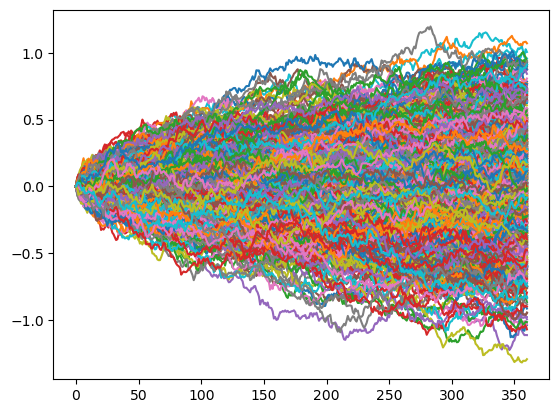

In [71]:
time = np.linspace(0,M,M+1)
X = create_BB(number_paths, M, sigma, g, delta_t)
plt.plot(time, X.T)
plt.show()

Standard Brownian Motion berechnen

In [154]:
def create_standard_bm(sigma, number_paths, M, delta_t):
    w = np.empty((number_paths,M))

    for m in range(number_paths):
        #create lower trinangular matrix with ones
        lower_tri_matr = np.tril(np.ones([M,M]))
        A = sigma * math.sqrt(delta_t)*lower_tri_matr #! hier sigma multipiziert, ist das so richtig?
        #create Brownian motion
        w[m,:] = A.dot(np.random.randn(M))
        
    w = np.concatenate((np.reshape(np.zeros(number_paths),(number_paths,1)), w),axis=1)
    return w

ab hier komplette MBS standard MC Simulation

i_K und w_k für MBS erstellen

In [142]:
def create_i_k(QMC, number_paths, M, sigma, g, delta_t):
    if BB == True:
        X = create_BB(number_paths, M, sigma, g, delta_t)       
    elif BB == False:
        X = create_standard_bm(sigma, number_paths, M, delta_t)
        
    #create differences of the Wiener process
    delta_X = np.diff(X, axis = 1)

    i_k = np.empty((number_paths,M+1))     #+1 weil i_0 mit drin ist
    i_k[:,0] = i_0
    for n in range(number_paths):
        for j in range(M):
            j = j+1
            i_k[n,j] = i_k[n,j-1]*K_0*math.exp(delta_X[n,j-1])
    return i_k


def create_w_k(i_k, K1, K2, K3, K4, number_paths, M):
    w_k = np.empty((number_paths,M))
    w_k = K1+K2*np.arctan(K3 * i_k + K4)


[[ 0.          0.01925507  0.02968878 ...  0.52220411  0.53808137
   0.52843185]
 [ 0.         -0.00656266  0.00839623 ...  0.28470526  0.28167274
   0.27974842]
 [ 0.         -0.01253245  0.00595468 ...  0.3401642   0.34175583
   0.34067114]
 ...
 [ 0.          0.02120646  0.04817037 ...  0.06191458  0.03879939
   0.05772857]
 [ 0.         -0.03061454 -0.03169336 ... -0.32716518 -0.30533877
  -0.28999494]
 [ 0.         -0.01322061 -0.02299185 ... -0.66151328 -0.68732879
  -0.72925571]]


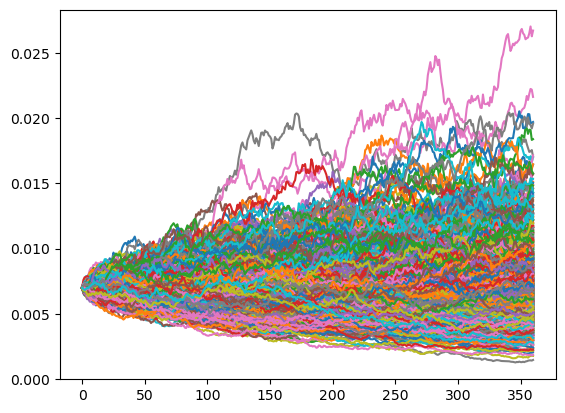

In [157]:
i_k = create_i_k(BB, number_paths, M, sigma, g, delta_t)
plt.plot(i_k.T)
plt.show()

MBS MC Simulation

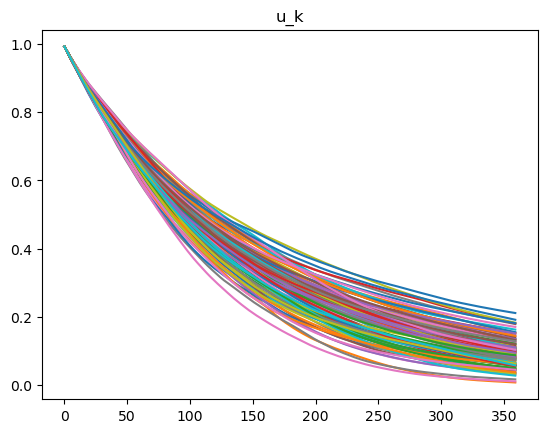

13066.409369002598


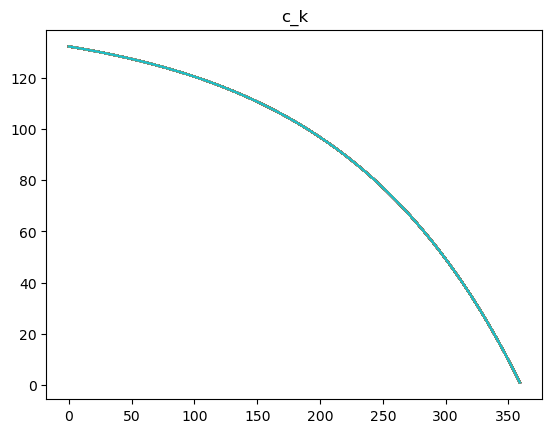

In [73]:
u_k = np.empty((number_paths,M))
for k in range(M):
    u_k[:,k] = np.prod(1/(i_k[:,0:k+1] + 1), axis = 1)

c_k = np.ones((number_paths,M))
for k in range(M):                 
    for j in range(M - (k+1)):
        j = j + 1                   #damit man nicht bei 0 anfängt, erster Summand ist schon 1
        c_k[:,k] = c_k[:,k] + (1 + i_k[:,0])**(-j)

r_k = np.empty((number_paths, M))
for k in range(M):
    r_k[:,k] = np.prod(1-w_k[:,0:k+1] , axis = 1)

m_k = np.empty((number_paths, M))
for k in range(M):
    m_k[:,k] = c*r_k[:,k]*((1-w_k[:,k]) + w_k[:,k]*c_k[:,k])


plt.plot(u_k.T)
plt.title("u_k")
plt.show()


plt.plot(c_k.T)
plt.title("c_k")
plt.show




expectation = np.sum(np.sum(u_k * m_k,axis=1))/number_paths
print(expectation)

<function matplotlib.pyplot.show(close=None, block=None)>

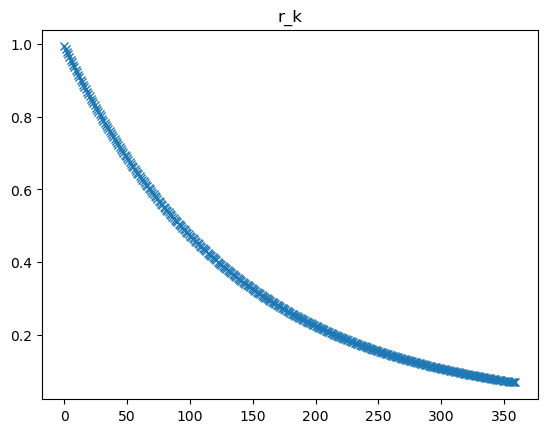

In [74]:
#plt.plot(m_k.T)
#plt.title("m_k")
#plt.show

plt.plot(r_k[5,:].T,'x')
plt.title("r_k")
plt.show